## Set up

In [1]:
import velocycle as vc
from velocycle import *
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import pyro
import copy
import scipy
import pycircstat
import pickle
from scipy.stats import pearsonr
from scipy.linalg import lstsq
import statsmodels.api as sm
import seaborn as sns
from adjustText import adjust_text
# scRNA-seq
import scanpy as sc
import anndata

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
USE_GPU = False
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use CPU


In [2]:
workdir = '/work/Jupyterlab/Project/CellCycle/02.Dynamic_CC/02.Infer_CC_pseudotime/'
datadir = f"{workdir}data/"
plotdir = f"{workdir}plots/"
version = '01'

In [5]:
sc.set_figure_params(dpi=100)

## Load data

In [6]:
fl_hsc = sc.read_h5ad("/work/Jupyterlab/Project/CellCycle/02.Dynamic_CC/01.Identify_G0_HSCs/data/FL_rna_clustered.v00.h5ad")
anno = pd.read_csv("/work/Jupyterlab/Project/CellCycle/02.Dynamic_CC/01.Identify_G0_HSCs/data/11.FLHSC_withG0label_byBMgset_cellmeta.csv",index_col=0)

#### Assign G0 label

In [7]:
fl_hsc.obs['G0_label'] = anno.loc[fl_hsc.obs.index,'G0_label']

In [8]:
fl_hsc.obs['G0_label'].value_counts()

G0_label
G1     23987
S      14878
G2M     5411
G0      1777
Name: count, dtype: int64

In [9]:
fl_hsc.layers['counts'] = fl_hsc.X.copy()

#### Remove G0 cells

In [28]:
data = fl_hsc[fl_hsc.obs['G0_label'] != 'G0']

In [11]:
data.shape

(44276, 36601)

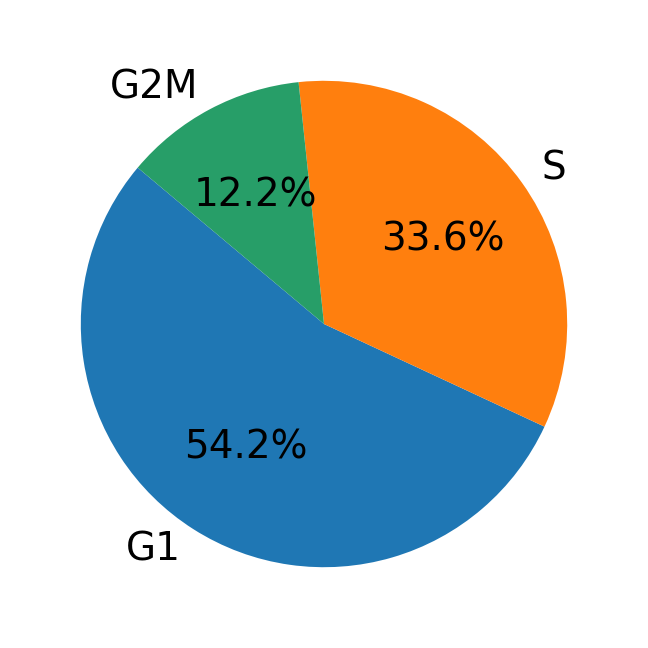

In [12]:
value_counts = data.obs['Phase'].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.index=value_counts_df['Phase']
value_counts_df = value_counts_df.reindex(['G1','S','G2M'])
plt.figure(figsize=(4,4))
plt.pie(value_counts_df['count'], labels=value_counts_df.index, autopct='%1.1f%%', startangle=140)
plt.show()

## Preprocessing

In [30]:
data.layers['spliced'] = data.X.copy()
data.layers['unspliced'] = data.X.copy()

In [31]:
sc.pp.filter_genes(data, min_cells=int((data.n_obs)*0.05))
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.1].copy()

In [32]:
preprocessing.normalize_total(data)

In [33]:
batch_design_matrix = preprocessing.make_design_matrix(data, ids="libraryID")

In [34]:
cycle_prior = cycle.Cycle.trivial_prior(gene_names=utils.get_cycling_gene_set(size='Medium',species='Human'), harmonics=1)

In [35]:
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [36]:
data_to_fit.shape

(44276, 172)

#### gene prior

In [35]:
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

# Mean prior
S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
cycle_prior.set_means(S_frac_means)

# Standard deviation prior
nu0std = np.std(np.log(S+1), axis=0)/2
S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
cycle_prior.set_stds(S_frac_stds)

#### phase prior

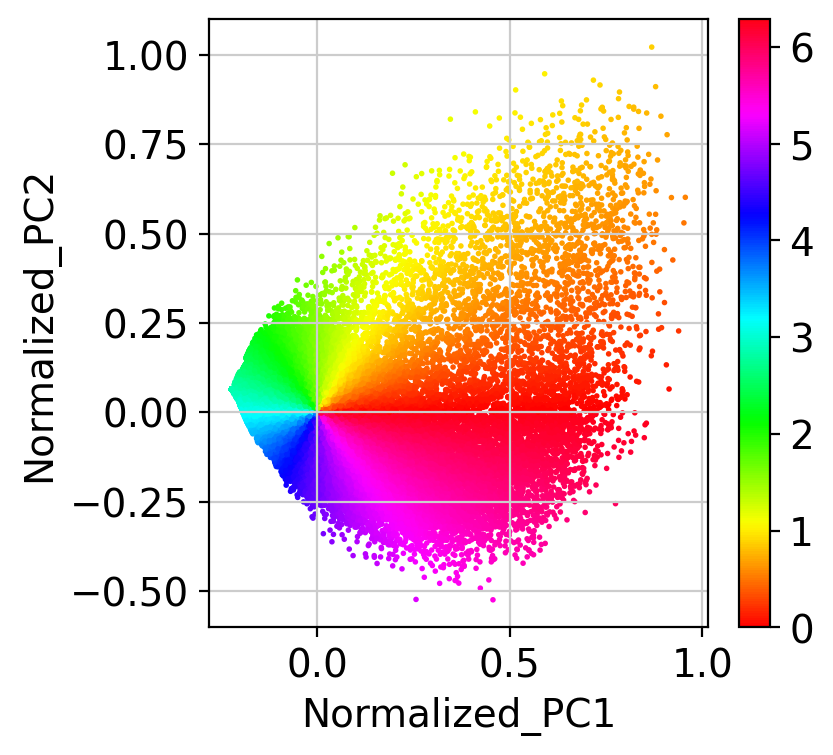

In [41]:
data_to_fit.layers["S_sz_log"] = np.log(data_to_fit.layers["S_sz"]+1)
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, 
                                               genes_to_use=utils.get_cycling_gene_set(size="Small", species="Human"), 
                                               layer='S_sz_log',
                                               concentration=5.0, plot=True, small_count=1)

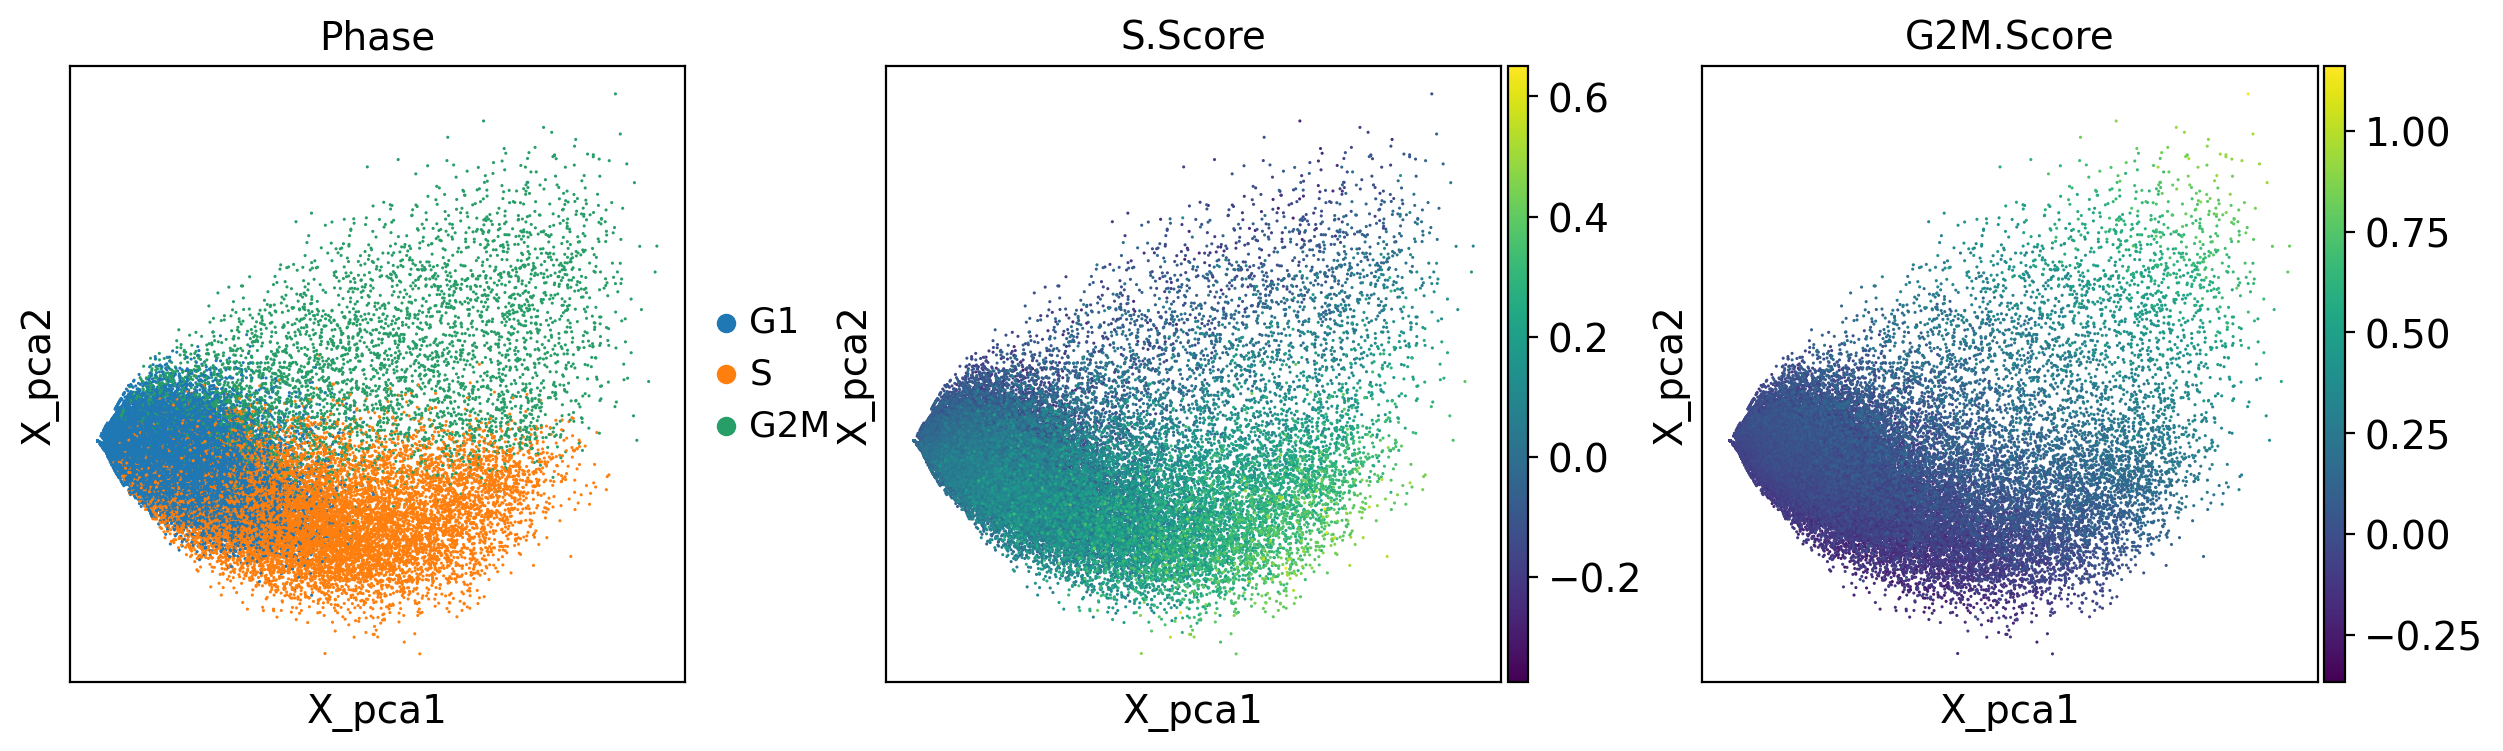

In [42]:
data.obsm['X_pca'] = phase_prior.pcs
cyclec=['G1','S','G2M']
data.obs['Phase'] = data.obs['Phase'].astype("category")
data.obs['Phase'] = data.obs['Phase'].cat.reorder_categories(cyclec, ordered=True)

plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.embedding(data,basis='X_pca',color=['Phase','S.Score','G2M.Score'],size=5)

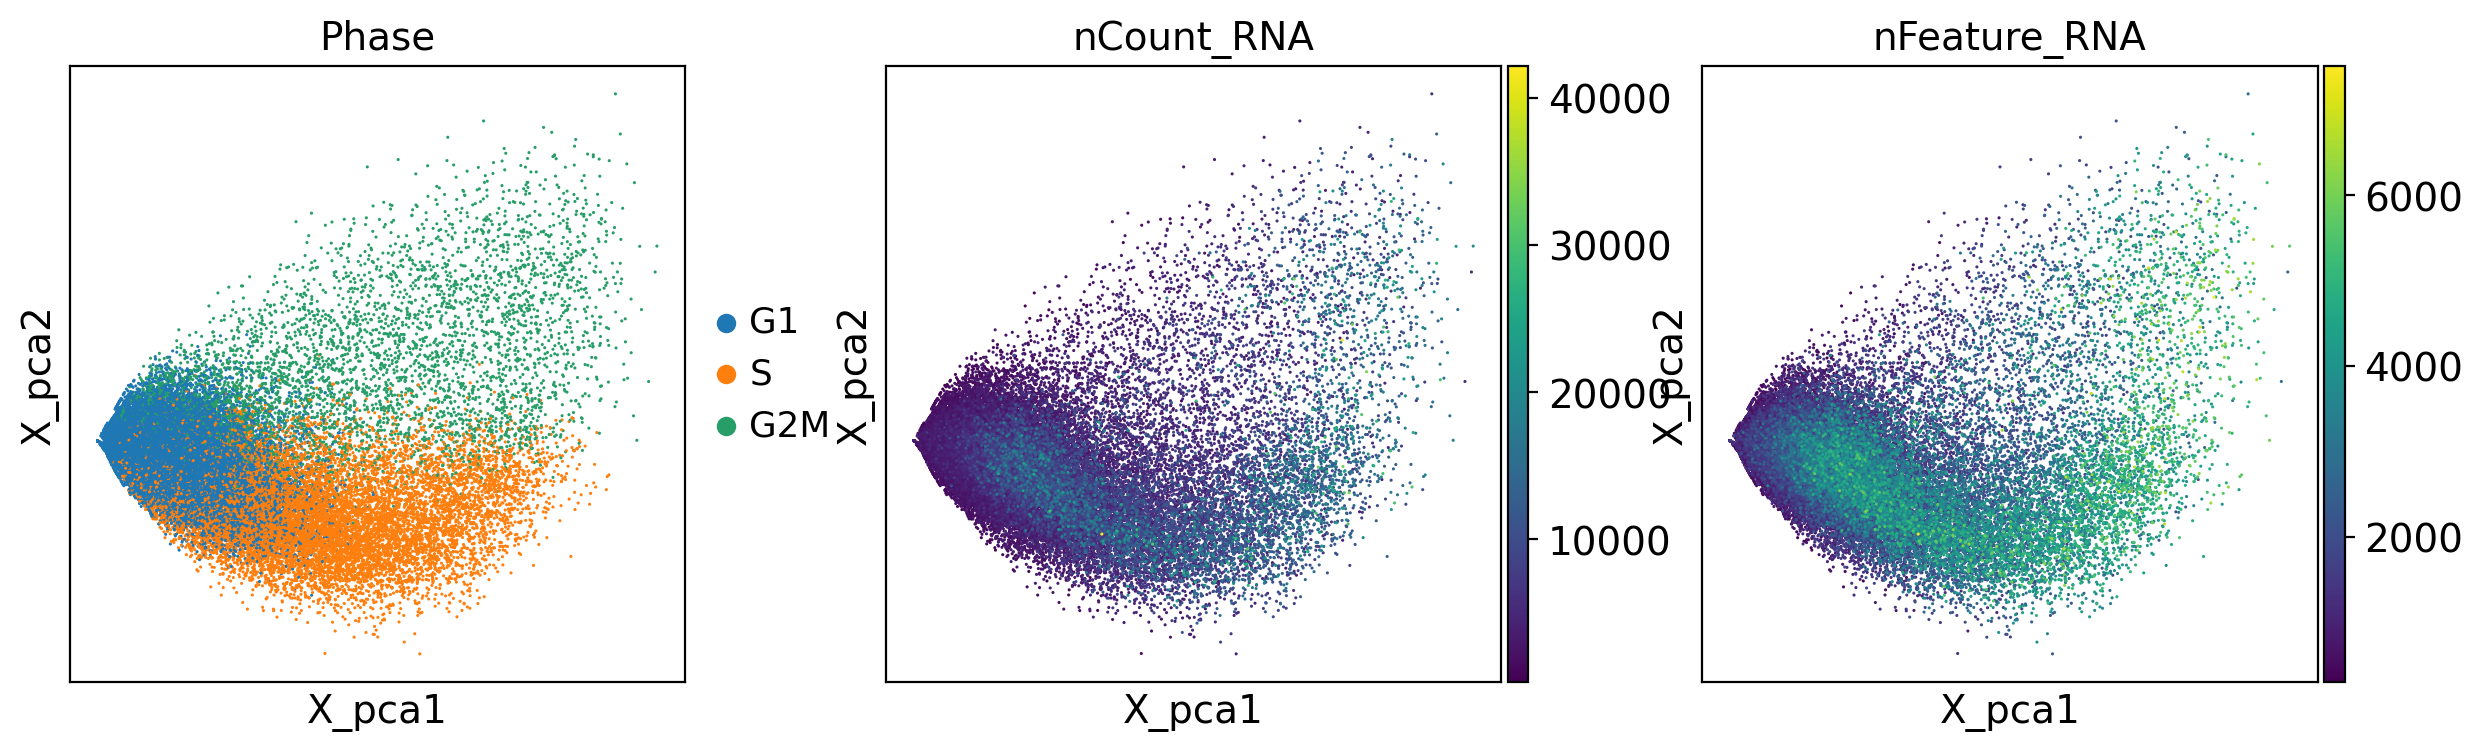

In [38]:
sc.pl.embedding(data,basis='X_pca',color=['Phase','nCount_RNA','nFeature_RNA'],size=5)

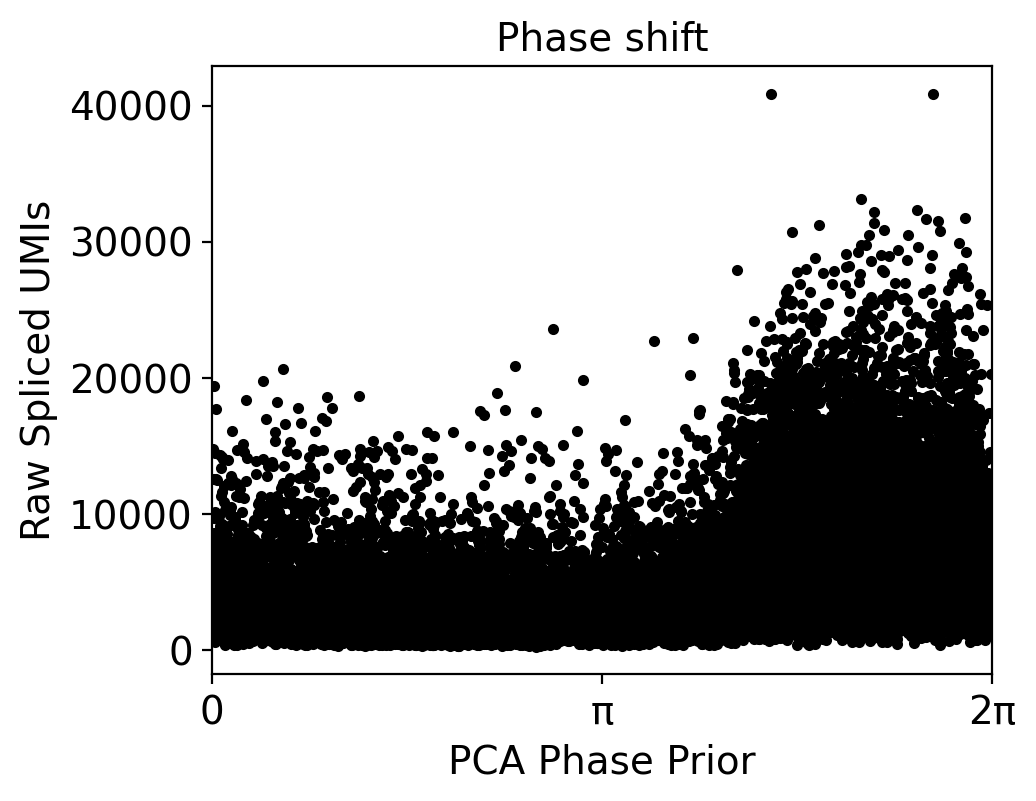

In [44]:
plt.rcParams["figure.figsize"] = (5, 4)
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.title('Phase shift')
plt.grid('')
plt.show()

## Manifold Learning

In [49]:
pyro.clear_param_store()
σΔν = torch.ones((batch_design_matrix.shape[1], S.shape[1], 1))
σΔν[0, :, :] = 0.001
σΔν[1:, :, :] = 0.1
condition_on_dict = {}
# Call a preprocessing function to metaparameters to provide to Pyro
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix,
                                          n_harmonics=1,
                                          σΔν=σΔν.float().to(device),
                                          device = device,
                                          condition_on=condition_on_dict)

In [50]:
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar)

In [51]:
phase_fit.check_guide()

 Trace Shapes:                 
  Param Sites:                 
        ν_locs    172     1 3  
      ν_scales    172     1 3  
       Δν_locs     48   172 1  
      ϕxy_locs        44276 2  
shape_inv_locs          172 1  
 Sample Sites:                 
    cells dist              |  
         value        44276 |  
    genes dist              |  
         value          172 |  
  batches dist              |  
         value           48 |  
        ν dist    172     1 | 3
         value    172     1 | 3
shape_inv dist    172     1 |  
         value    172     1 |  
       Δν dist 48 172     1 |  
         value 48 172     1 |  
      ϕxy dist        44276 | 2
         value        44276 | 2


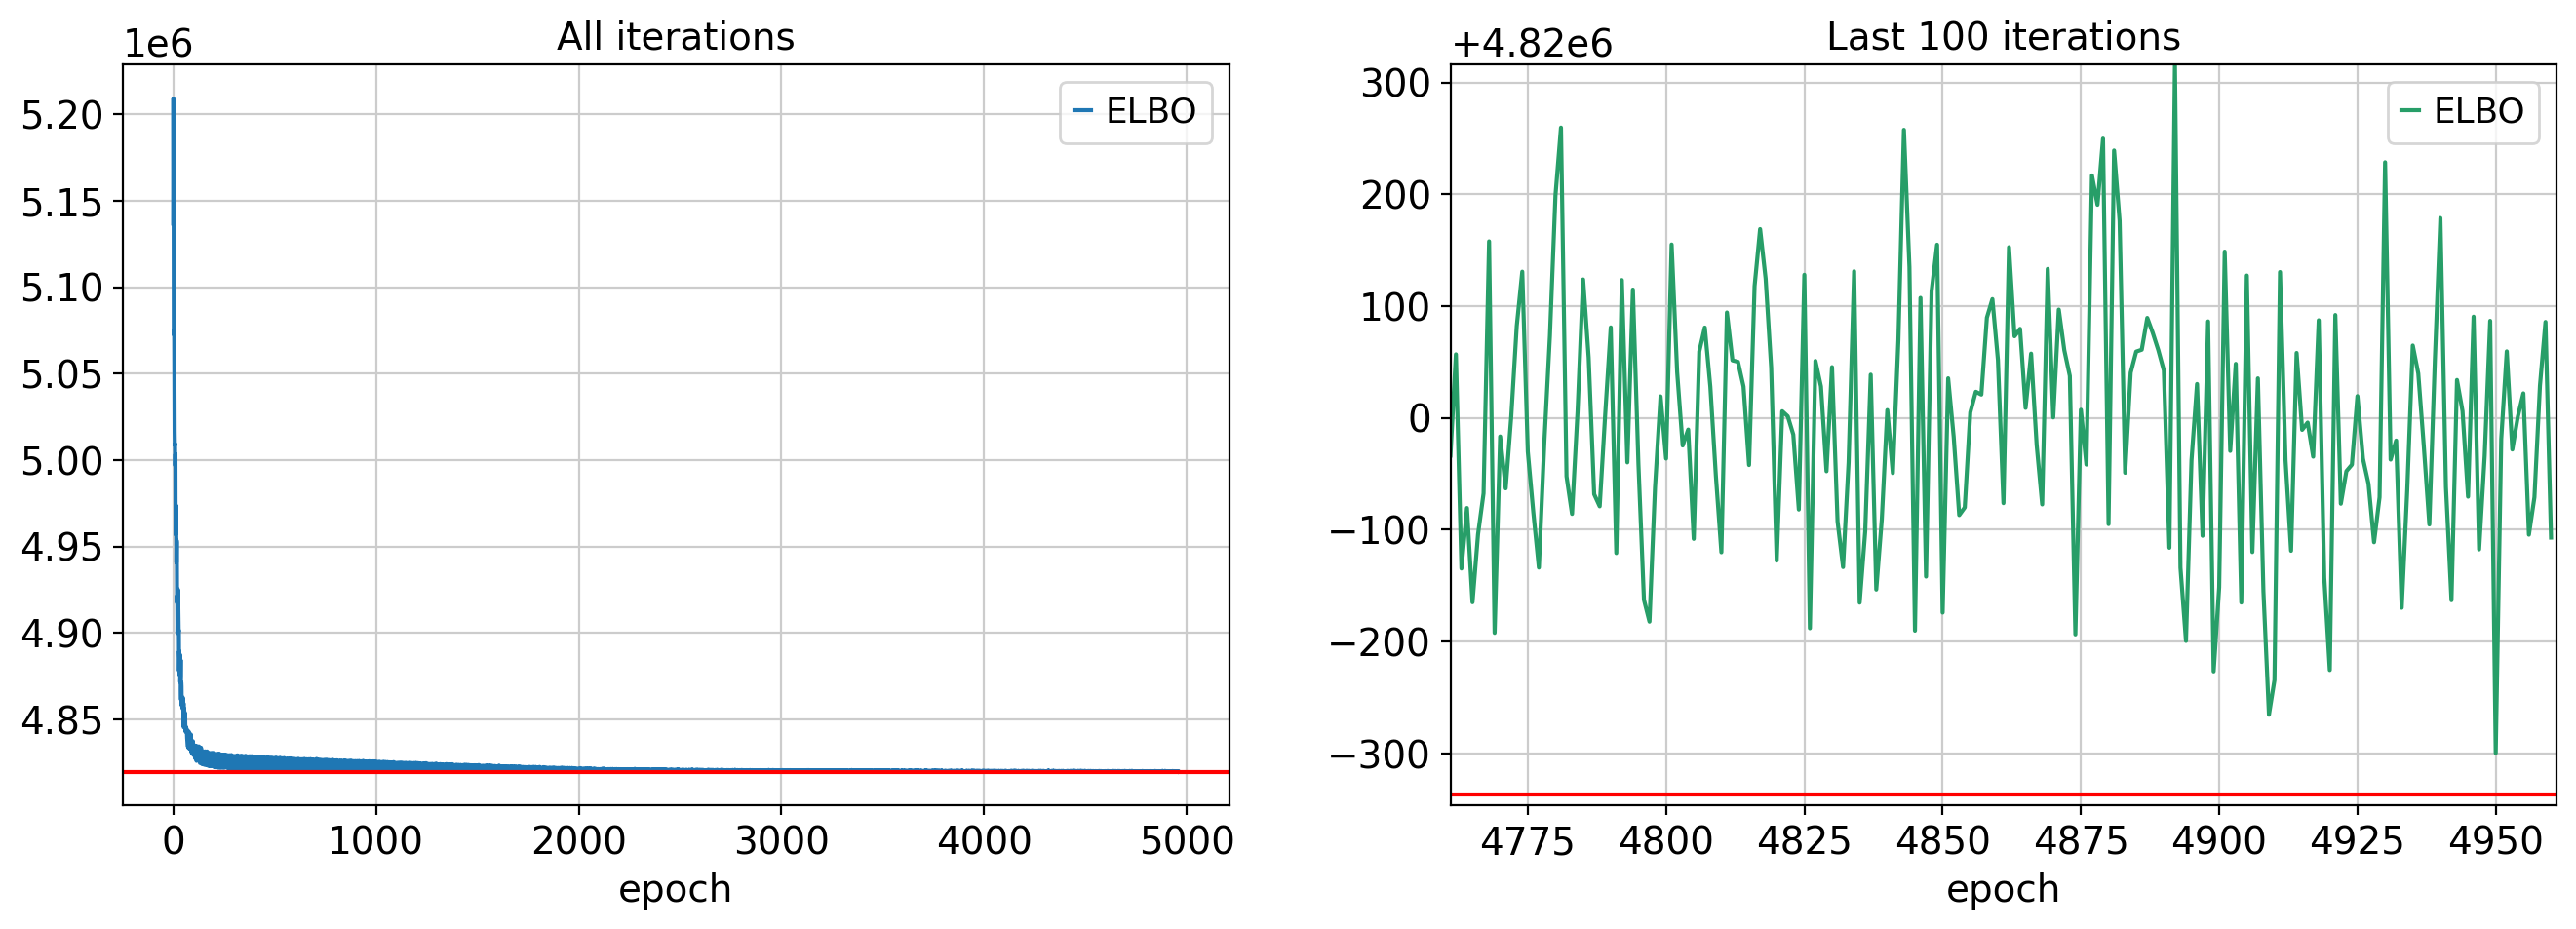

In [52]:
num_steps = 5000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

In [53]:
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [54]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().numpy() # raw counts
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().numpy() 

### Manifold

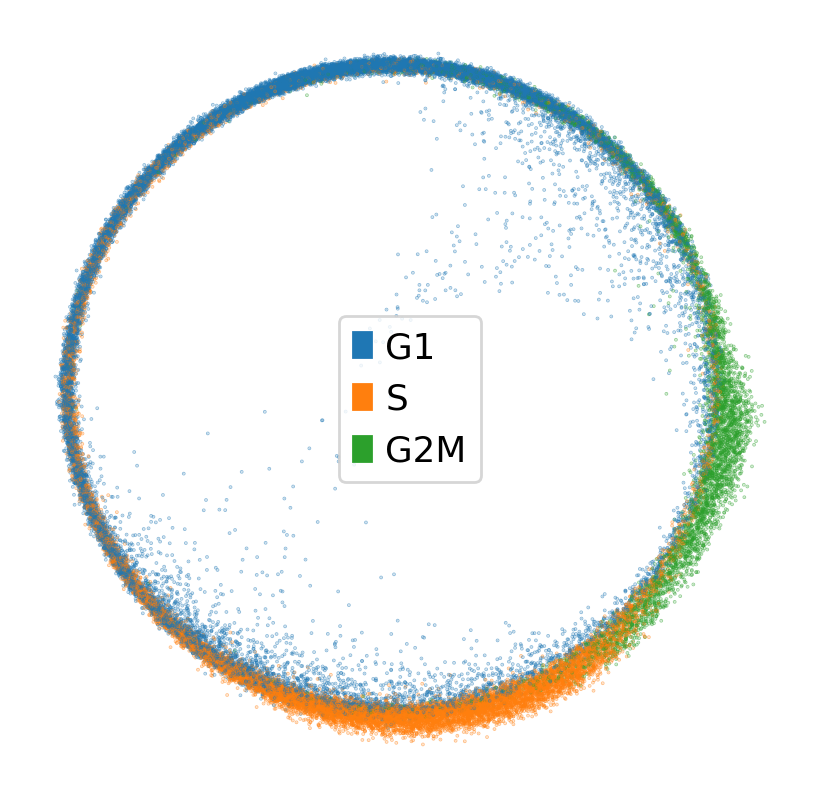

In [55]:
# Get the the phase coordinates
phiplot = pd.DataFrame(phase_pyro.phi_xy).transpose()
phiplot['Phase'] = data.obs['Phase']
color_dict = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
colors = phiplot['Phase'].map(color_dict)

fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.scatter(phiplot['phi_x'], phiplot['phi_y'], c=colors,s=0.1,alpha=0.5)
handles = [mpatches.Patch(color=color, label=phase) for phase, color in color_dict.items()]
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid('')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles=handles)
plt.show()

### Harmonics

In [56]:
xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

phis_df = pd.DataFrame([angle, r])
phis_df.columns = data_to_fit.var.index

cycle_data_frame = pd.concat([phase_fit.cycle_pyro.means, phase_fit.cycle_pyro.stds, phis_df]).T
cycle_data_frame.columns = ["nu0 mean", "nu1sin mean", "nu1cos mean", "nu0 std", "nu1sin std", "nu1cos std", "peak_phase", "amplitude"]
cycle_data_frame["is_seurat_marker"] = [True if i in list(utils.S_genes_human)+list(utils.G2M_genes_human) else False for i in cycle_data_frame.index]

In [57]:
cycle_data_frame = cycle_data_frame.sort_values(by='amplitude',ascending=False)
cycle_data_frame[:50]

nu0 mean  nu1sin mean  nu1cos mean   nu0 std  nu1sin std  \
CENPF    -1.186214    -0.006133     1.838278  0.007757    0.010840   
TOP2A    -1.418632    -0.230658     1.859459  0.008506    0.011609   
MKI67    -1.923060    -0.274127     1.919895  0.009286    0.014641   
CENPE    -1.672145    -0.253022     1.668898  0.009061    0.012909   
BRIP1    -0.699865    -1.149095     0.042781  0.006769    0.008388   
ASPM     -1.596152    -0.345994     1.459793  0.010224    0.011765   
HELLS    -0.630246    -0.869262    -0.228079  0.005937    0.007338   
POLA1    -0.452729    -0.712801    -0.428746  0.006118    0.006439   
HMGB2    -0.276583    -0.146147     0.850487  0.006422    0.008575   
SMC4     -0.706255    -0.342285     0.770594  0.006508    0.008336   
TPX2     -1.722012    -0.147743     1.239545  0.009147    0.013664   
KIF11    -1.693401    -0.394162     1.127226  0.010521    0.013200   
NUSAP1   -1.731787    -0.407665     1.109366  0.010264    0.013112   
DTL      -1.398210    -1.040635     0.140330  0.008816    0.010644   
ATAD2    -0.508503    -0.722401     0.146281  0.005695    0.007862   
RRM2     -1.671585    -0.762975     0.943702  0.010233    0.013145   
CIT      -1.593720    -0.682431     0.861514  0.010107    0.012550   
TAOK3     1.525103     0.216003    -0.265963  0.002842    0.003823   
NASP      0.069547    -0.456912    -0.209308  0.005193    0.005737   
ANLN     -2.190806    -0.483811     1.136557  0.012052    0.015405   
DLGAP5   -2.320320     0.074515     1.288944  0.013794    0.016710   
KIF14    -1.805717    -0.339525     1.036651  0.011374    0.014249   
NUF2     -2.219015    -0.516824     1.129069  0.011853    0.017307   
GTSE1    -2.608866    -0.287532     1.378809  0.014317    0.019251   
KIF2C    -2.405613    -0.492715     1.210329  0.012910    0.017929   
CDC25C   -2.454058    -0.523161     1.177745  0.015006    0.018955   
MCM4     -1.060446    -0.684851    -0.236631  0.007614    0.008847   
NDC80    -2.375449    -0.468178     1.138762  0.013770    0.017266   
CDK1     -2.406044    -0.362563     1.067914  0.013007    0.016442   
SENP6     0.380283     0.299857    -0.327880  0.004672    0.006279   
BUB1     -2.187003    -0.252651     1.059143  0.012065    0.015949   
KIF23    -2.609370    -0.266304     1.222016  0.014645    0.019721   
CLSPN    -1.773619    -0.924381     0.130802  0.010346    0.012858   
AURKB    -2.773648    -0.347207     1.266722  0.015478    0.020830   
TTK      -2.447957    -0.443688     1.006931  0.012370    0.016580   
BUB1B    -1.915648    -0.499215     0.881473  0.010131    0.015067   
PUM1      0.504023     0.250689    -0.277253  0.004403    0.005685   
UHRF1    -0.952594    -0.576309    -0.342485  0.009107    0.009422   
ATRX      0.619994     0.249899    -0.261351  0.004033    0.005675   
ANKRD17   0.615566     0.182198    -0.309223  0.004412    0.005643   
CDCA2    -2.697703    -0.372299     1.132703  0.014614    0.021400   
CKAP5    -0.798587     0.032181     0.590516  0.007555    0.010120   
CDC45    -2.356905    -0.990745     0.146153  0.012161    0.014377   
MCM5     -1.395936    -0.654960    -0.309268  0.008831    0.011873   
RAD51AP1 -2.404428    -0.848556     0.552905  0.012277    0.015638   
TACC3    -1.149834    -0.115153     0.652759  0.008261    0.011158   
NCAPD2   -1.625234    -0.120400     0.722879  0.010586    0.013238   
SFPQ      0.562895     0.237612    -0.181739  0.004127    0.005099   
KIF20B   -1.234279    -0.320152     0.604790  0.007807    0.011870   
TMPO     -0.271333    -0.292316     0.332712  0.006249    0.007389   

          nu1cos std  peak_phase  amplitude  is_seurat_marker  
CENPF       0.010841    6.279849   1.928334              True  
TOP2A       0.012254    6.159770   1.894967              True  
MKI67       0.012209    6.141362   1.858714              True  
CENPE       0.013984    6.132721   1.797739              True  
BRIP1       0.010872    4.749602   1.775996              True  
ASPM        0.013989    6.050464   1.765314            

In [58]:
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests

In [59]:
def wald_joint_test(
    df,
    sin_mean_col="nu1sin mean",
    cos_mean_col="nu1cos mean",
    sin_sd_col="nu1sin std",
    cos_sd_col="nu1cos std",
    cov_col=None,    # optional: name of column with Cov(nu1sin, nu1cos) per gene
):
    rows = []
    for gene, r in df.iterrows():
        beta = np.array([r[sin_mean_col], r[cos_mean_col]])
        # Build 2x2 covariance matrix of the estimates
        cov = r[cov_col] if cov_col is not None else 0.0
        Sigma = np.array([[r[sin_sd_col]**2, cov],
                          [cov,               r[cos_sd_col]**2]])
        # Wald χ² statistic
        chi2_stat = beta @ np.linalg.inv(Sigma) @ beta
        p = 1 - chi2.cdf(chi2_stat, df=2)
        rows.append({
            "gene":gene,
            "chi2_stat": chi2_stat,
            "p_value": p,
            # nice to report effect size too
            "amplitude": np.log10(np.sqrt(beta[0]**2 + beta[1]**2)/ (r[sin_sd_col] + r[cos_sd_col]))
        })
    out = pd.DataFrame(rows)
    out["q_value_BH"] = multipletests(out["p_value"], method="fdr_bh")[1]
    return out.sort_values("amplitude",ascending=False)

In [60]:
res = wald_joint_test(
    cycle_data_frame,
    sin_mean_col="nu1sin mean",
    cos_mean_col="nu1cos mean",
    sin_sd_col="nu1sin std",
    cos_sd_col="nu1cos std",
    cov_col=None,          # set to the name of a covariance column if you have it
)

In [61]:
g2k = res[res['q_value_BH'] < 0.01]
print(g2k.shape)

(172, 5)


### Check gene fitting

In [69]:
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = cycle_data_frame.index[0:9]
gene_names = np.array(data_to_fit.var.index)

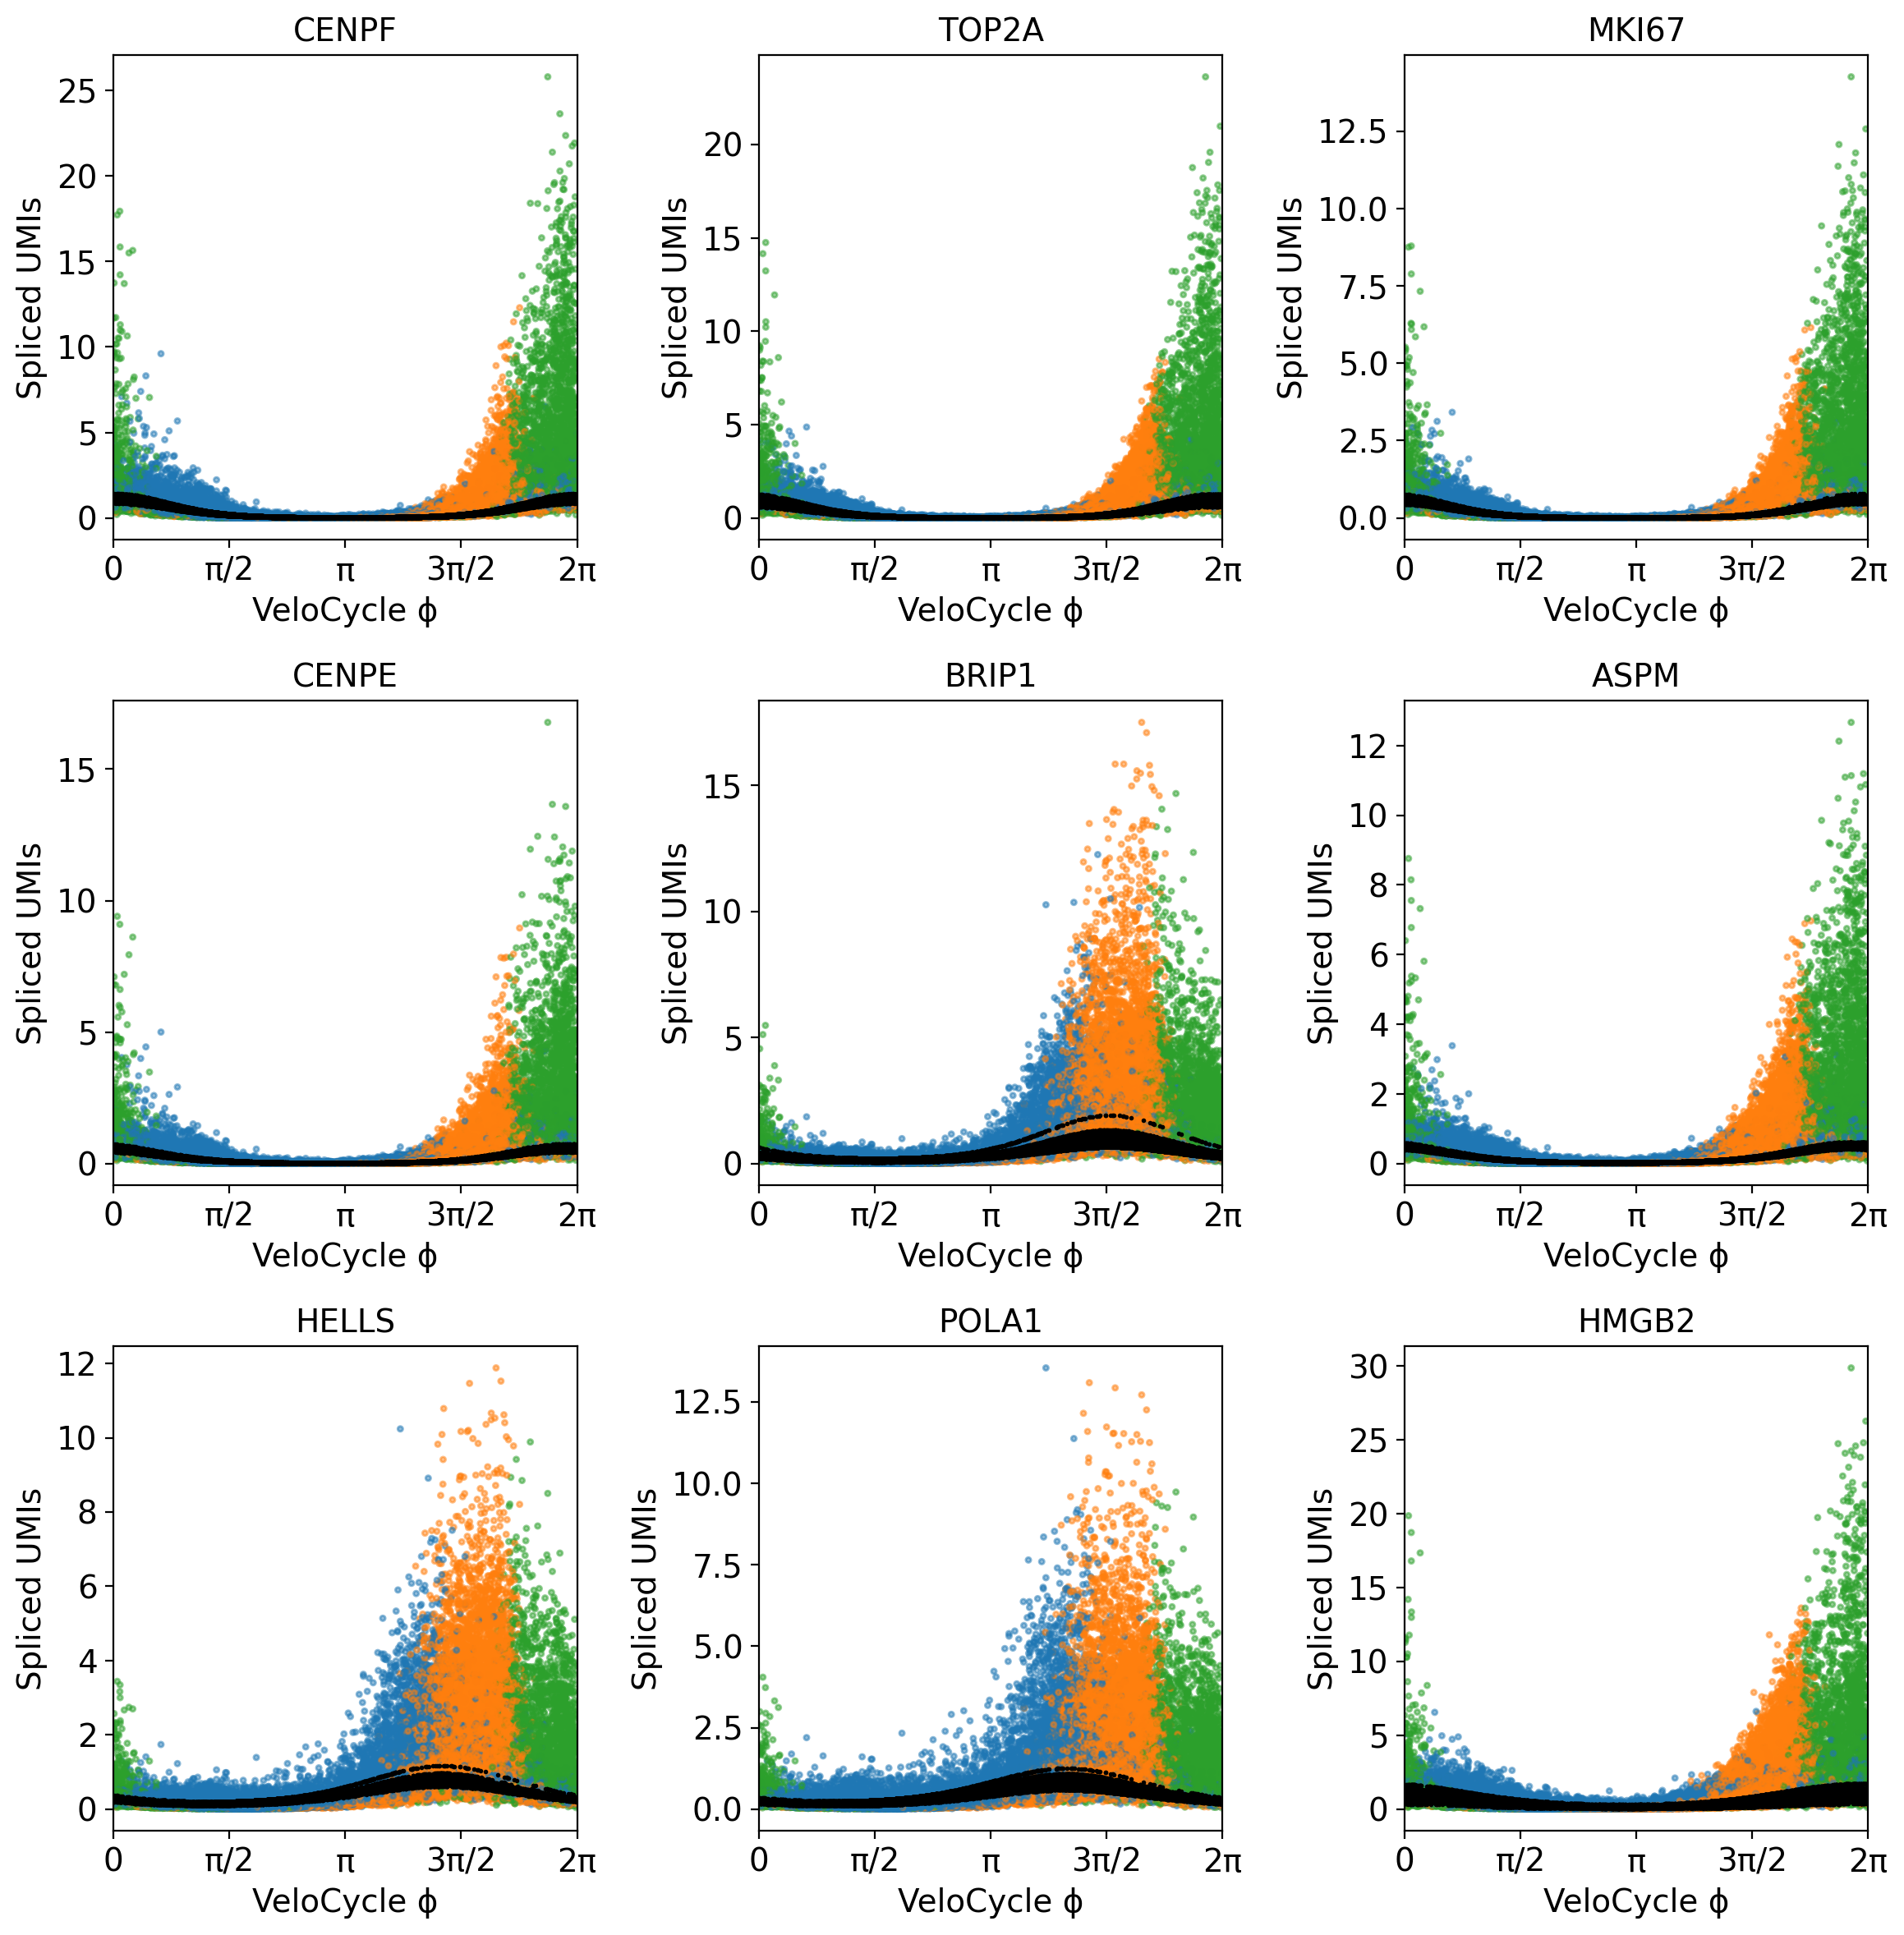

In [74]:
fig, axes = plt.subplots(3,3,figsize=(12,12))
axes = axes.flatten()
for i in range(0, len(gene_list)):
    g = gene_list[i]
    axes[i].scatter(phase_pyro.phis, 
                np.exp(fit_ElogS[np.where(gene_names==g)[0][0], :]), 
                s=5, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["Phase"]])
    axes[i].scatter(phase_pyro.phis, 
                np.exp(fit_ElogS2[np.where(gene_names==g)[0][0], :]), 
                s=1, c="black")
    axes[i].set_title(g)
    axes[i].grid('')
    axes[i].set_xlabel("VeloCycle ϕ")
    axes[i].set_ylabel("Spliced UMIs")
    axes[i].set_xlim(0, 2*np.pi)
    axes[i].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.tight_layout()
plt.savefig(f"{plotdir}01.VeloCycle_genefitting_top9.png",bbox_inches='tight',dpi=200)

### Check gene's peak phase

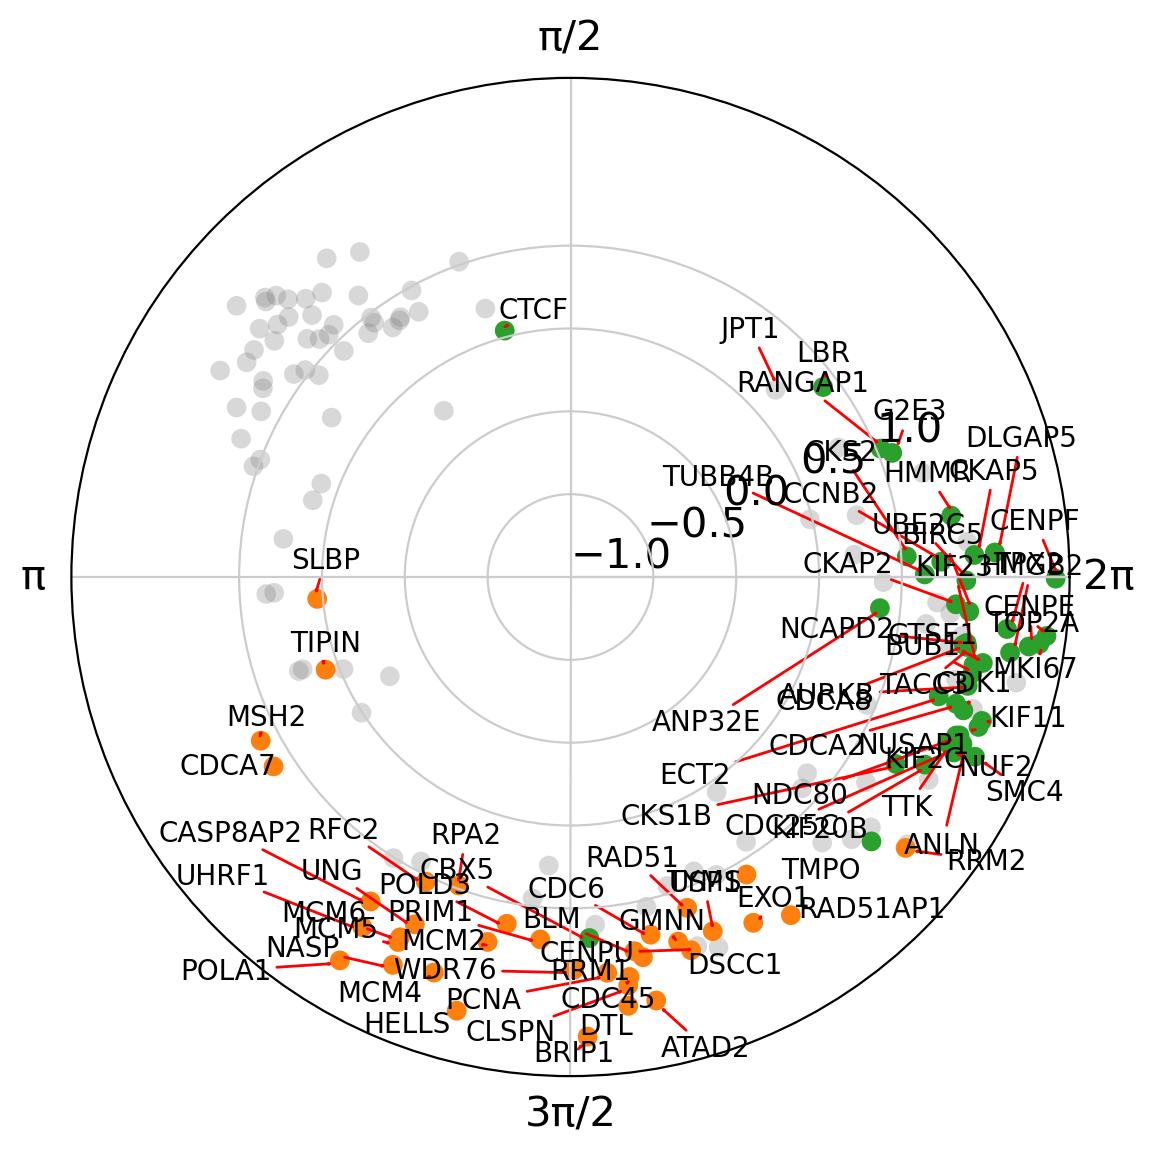

In [76]:
phase_data_frame = cycle_data_frame
keep_genes = [a.upper() for a in cycle_prior.means.columns]
gene_names = np.array(keep_genes)
S_genes_human = list(utils.S_genes_human)
G2M_genes_human = list(utils.G2M_genes_human)
phases_list = [S_genes_human, G2M_genes_human, [i.upper() for i in gene_names if i.upper() not in S_genes_human+G2M_genes_human]]

g = []
gradient = []
for i in range(len(phases_list)):
    for j in range(len(phases_list[i])):
        g.append(phases_list[i][j])
        gradient.append(i)

color_gradient_map = pd.DataFrame({'Gene': g,  'Color': gradient}).set_index('Gene').to_dict()['Color']
colored_gradient = pd.Series(gene_names).map(color_gradient_map)

xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

N=50
width = (2*np.pi) / N

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection='polar')

# First: only plot dots with a color assignment
angle_subset = angle[~np.isnan(colored_gradient.values)]
r_subset = r[~np.isnan(colored_gradient.values)]
color_subset = colored_gradient.values[~np.isnan(colored_gradient.values)]

# Remove genes with very low expression
angle_subset = angle_subset[r_subset>=-12]
color_subset = color_subset[r_subset>=-12]
gene_names_subset = gene_names[r_subset>=-12]
r_subset = r_subset[r_subset>=-12]

x=100
# Take a subset of most highly expressing genes to print the names 
angle_subset_best = angle_subset[r_subset>np.percentile(r_subset, x)]
color_subset_best = color_subset[r_subset>=np.percentile(r_subset, x)]
gene_names_subset_best = gene_names_subset[r_subset>=np.percentile(r_subset, x)]
r_subset_best = r_subset[r_subset>=np.percentile(r_subset, x)]

# Plot all genes in phases list
num2color = {0:"tab:orange", 1:"tab:green", 2:"tab:grey"}
ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=0.3, edgecolor='none', rasterized=True)

# Select and plot on top the genes marking S and G2M traditionally
angle_subset = angle_subset[color_subset!=2]
r_subset = r_subset[color_subset!=2]
gene_names_subset = gene_names_subset[color_subset!=2]
color_subset = color_subset[color_subset!=2]

ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=1, edgecolor='none',rasterized=True)

# Annotate genes
texts = []
for (i, txt), c in zip(enumerate(gene_names), colored_gradient.values):
    if txt in list(utils.get_cycling_gene_set(size='Small',species='Human')):
        ix = np.where(np.array(gene_names)==txt)[0][0]
        #ax.annotate(txt[0]+txt[1:].upper(), (angle[ix], r[ix]+0.02),fontsize=6)
        texts.append(plt.text(angle[ix], r[ix]+0.02, txt[0]+txt[1:].upper(), fontsize=10, ha='right'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.xlim(0, 2*np.pi)
plt.ylim(-1, )
plt.yticks([-1, -0.5, 0, 0.5, 1], size=15)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["", "π/2", "π", "3π/2", "2π"], size=15)
plt.tight_layout()
plt.savefig(f"{plotdir}01.VeloCycle_gene_poloarplot.png",bbox_inches='tight',dpi=200)

### Phase distribution

In [82]:
data.obs['VC_pseudotime'] = phase_pyro.phis

In [83]:
d4p = data.obs.copy()

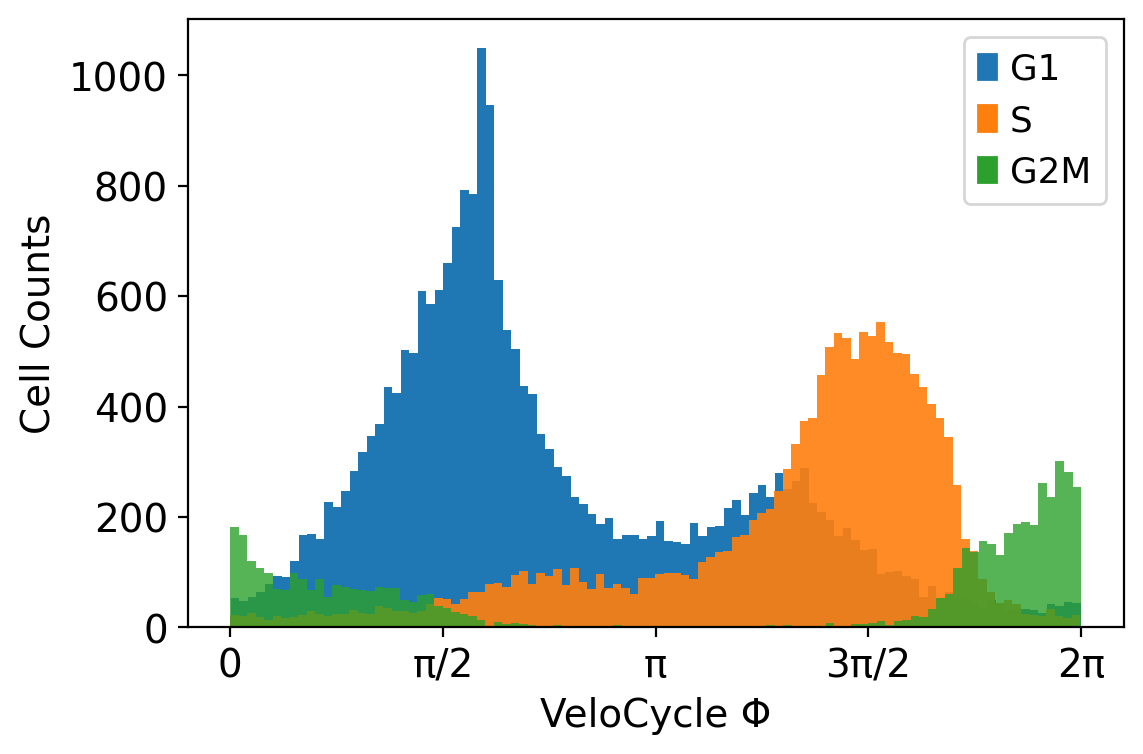

In [86]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
cdict = {'G1':'tab:blue','S':'tab:orange','G2M':'tab:green'}
#cmap = meta_011['if_quiescent'].map(cdict)
ax.hist(d4p[d4p['Phase']=='G1']['VC_pseudotime'],bins=100,color = 'tab:blue')
ax.hist(d4p[d4p['Phase']=='S']['VC_pseudotime'],bins=100,color = 'tab:orange',alpha=0.9)
ax.hist(d4p[d4p['Phase']=='G2M']['VC_pseudotime'],bins=100,color = 'tab:green',alpha=0.8)
#ax.hist(meta_011[meta_011['if_quiescent'] == False]['phis'],bins=50,color='tab:blue',alpha=0.8)
ax.grid('')
ax.set_ylabel('Cell Counts')
ax.set_xlabel('VeloCycle Φ')
handles = [mpatches.Patch(color=color, label=phase) for phase, color in cdict.items()]
ax.legend(handles=handles)
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.savefig(f"{plotdir}01.VeloCycle_phase_distribution.png",bbox_inches='tight',dpi=200)

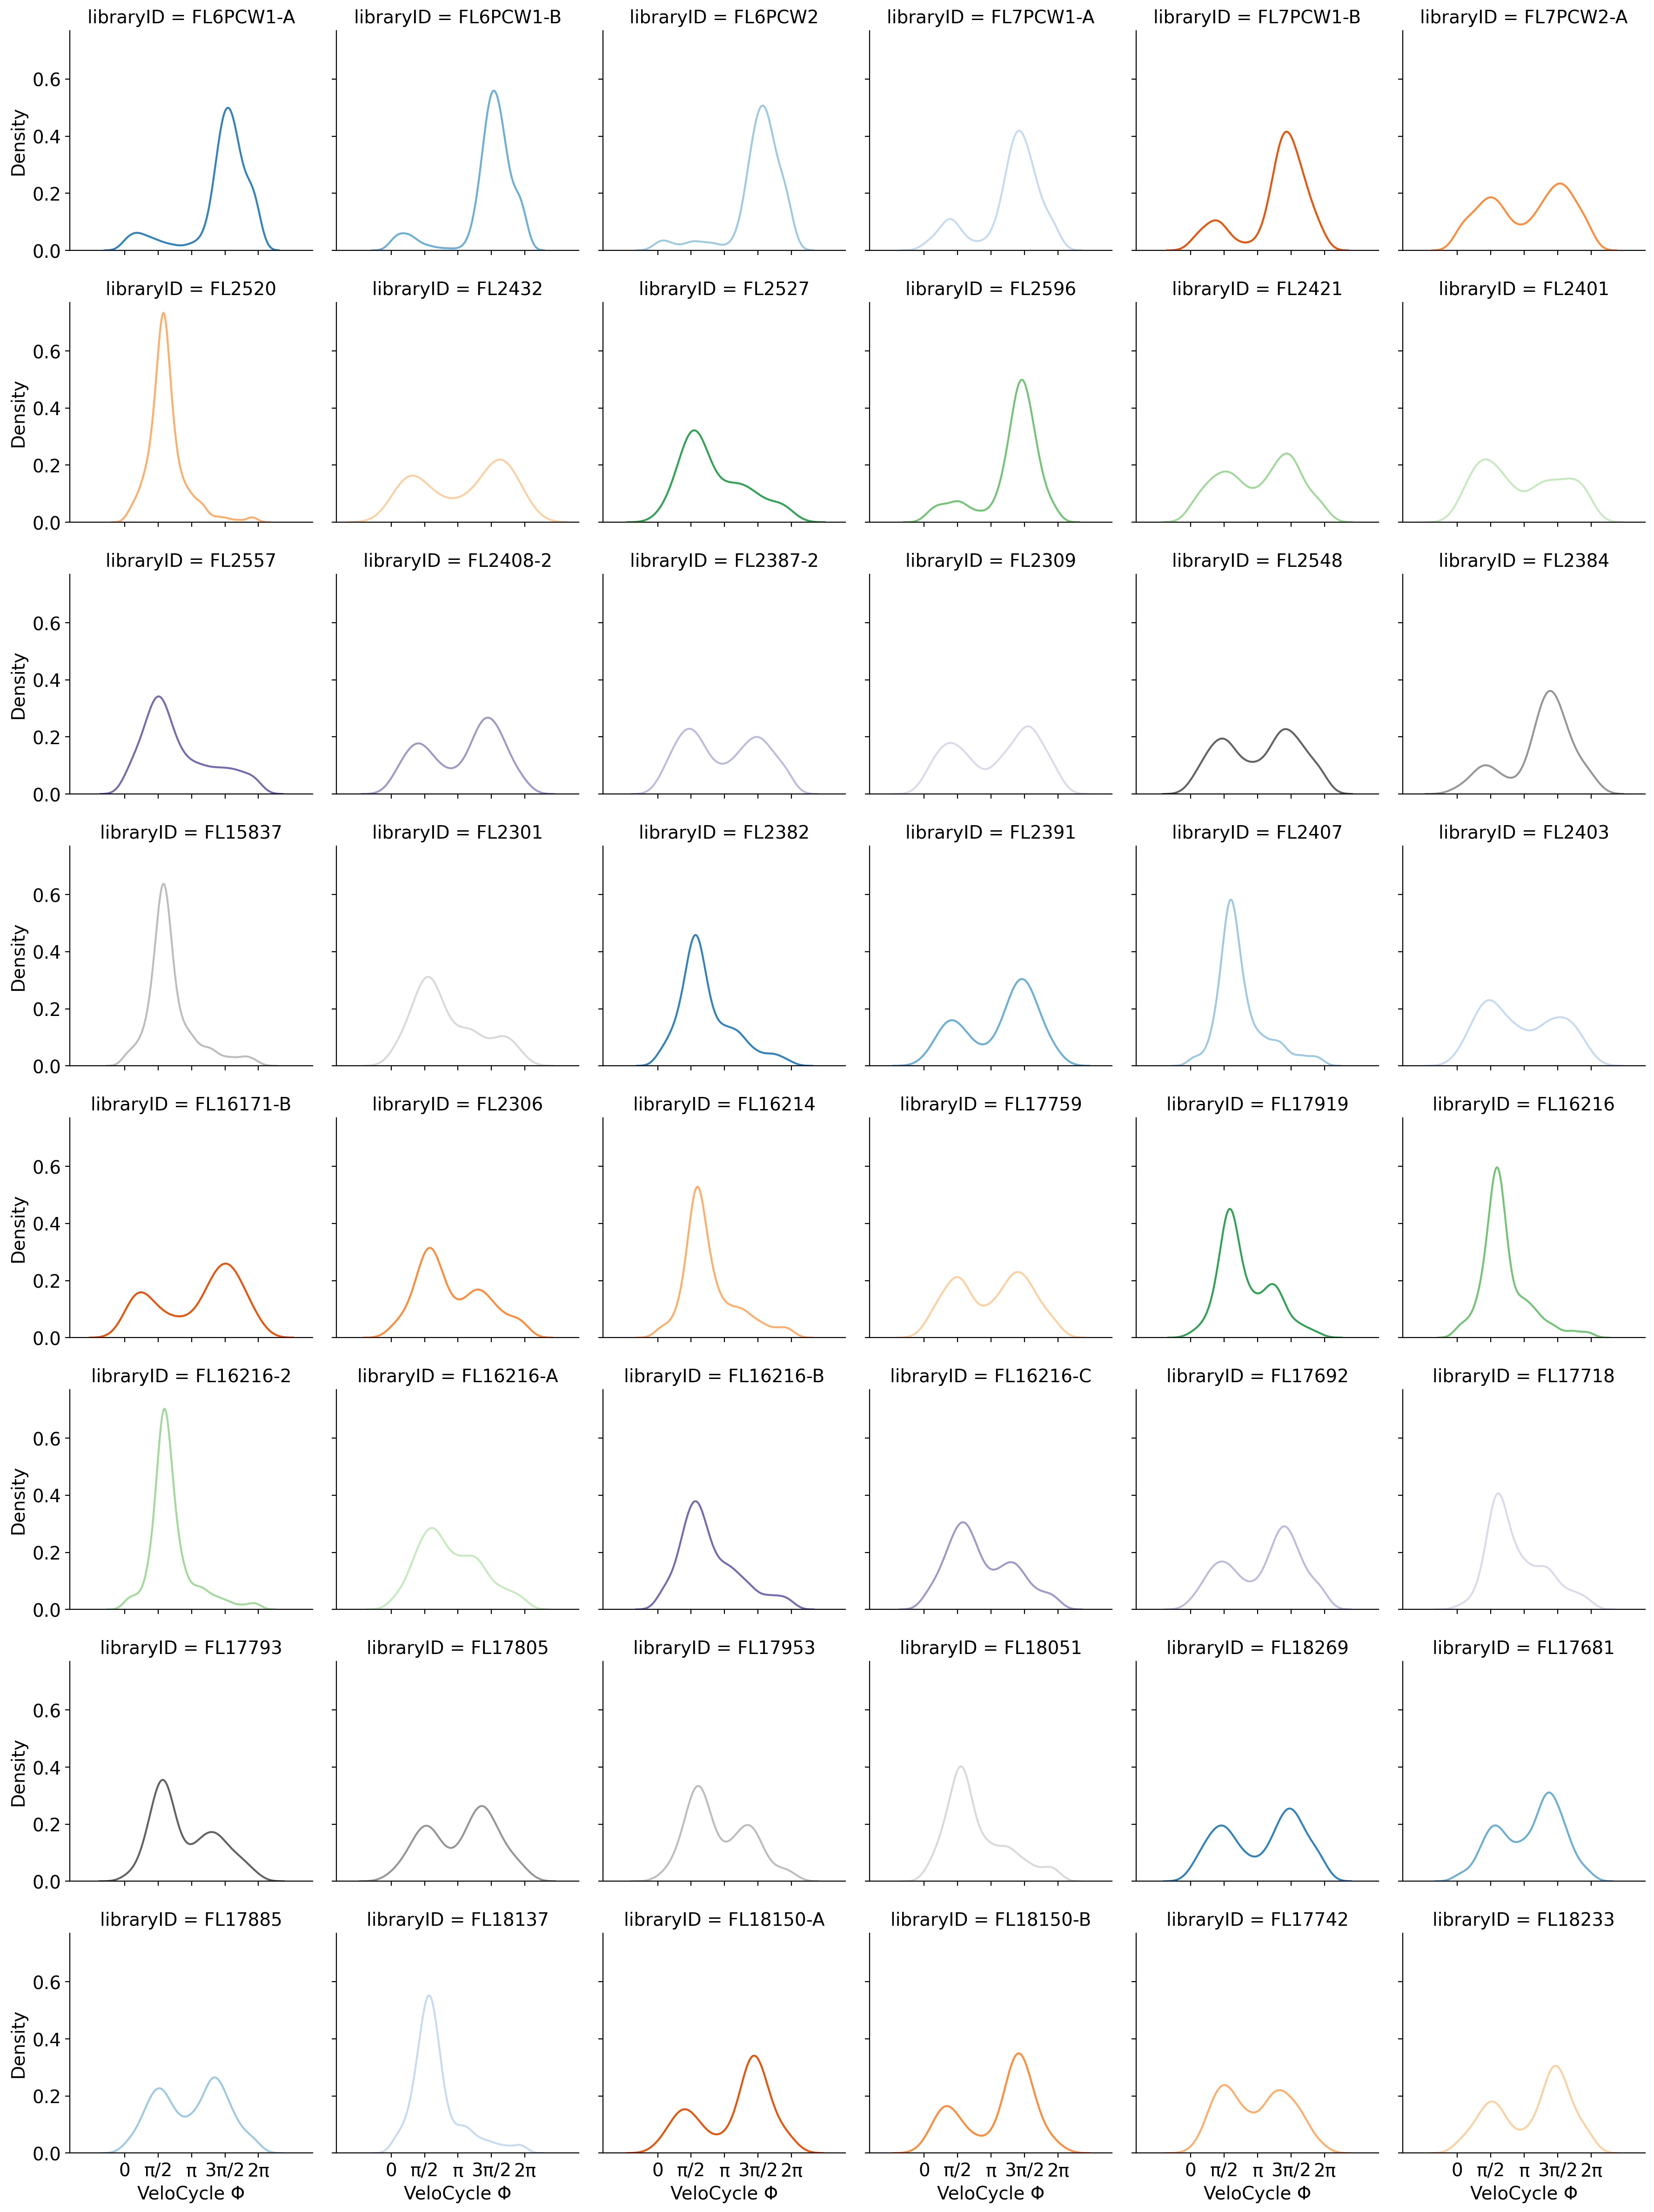

In [88]:
g = sns.FacetGrid(d4p, col="libraryID", hue="libraryID", palette="tab20c",
                     col_wrap=6, height=3)
g.map(sns.kdeplot,'VC_pseudotime')
for ax in g.axes.flat:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])  # or adjust range and step to fit your data
    ax.set_xticklabels(["0", "π/2", "π", "3π/2", "2π"])
    ax.grid('')
g.set_xlabels(label='VeloCycle Φ')
plt.savefig(f"{plotdir}01.VeloCycle_phase_distribution_bylibraryID.png",bbox_inches='tight',dpi=200)

## Save

#### gene harmonics

In [91]:
cycle_data_frame.to_csv(f'{datadir}01.VeloCycle_gene_harmonics.csv')

#### data to fit

In [93]:
data_to_fit.write_h5ad(f"{datadir}01.VeloCycle_data2fit.h5ad")

#### meta data

In [95]:
data.obs.to_csv(f"{datadir}01.VeloCycle_data2fit_metadata.csv")

#### phase fit

In [97]:
del phase_fit.metaparams
del phase_fit.metaparams_avg
pickle.dump(phase_fit, open(f"{datadir}01.VeloCycle_phase_fit.pkl", "wb"))